# Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Data Exploration notebook


#### We are examining images of slides of lymph tissue samples treated with contrast in order to detect cancer cells. This notebook contains some exploratory data analysis.

In [1]:
#includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
%matplotlib inline

from matplotlib.image import imread
import cv2    

from sklearn.utils import shuffle
import pickle
import sys
import seaborn as sns

In [2]:
#load data saved in data wrangling notebook
y=pickle.load(open("saved/y.p","rb"))
X=pickle.load(open("saved/X.p","rb"))
X_v=pickle.load(open("saved/X_vect.p","rb"))
#X_gray=pickle.load(open("saved/X_gray.p","rb"))
#X_gray_vect=pickle.load(open("saved/X_gra_vect.p","rb"))

##### Let's look at a few of the samples, in color and in grayscale

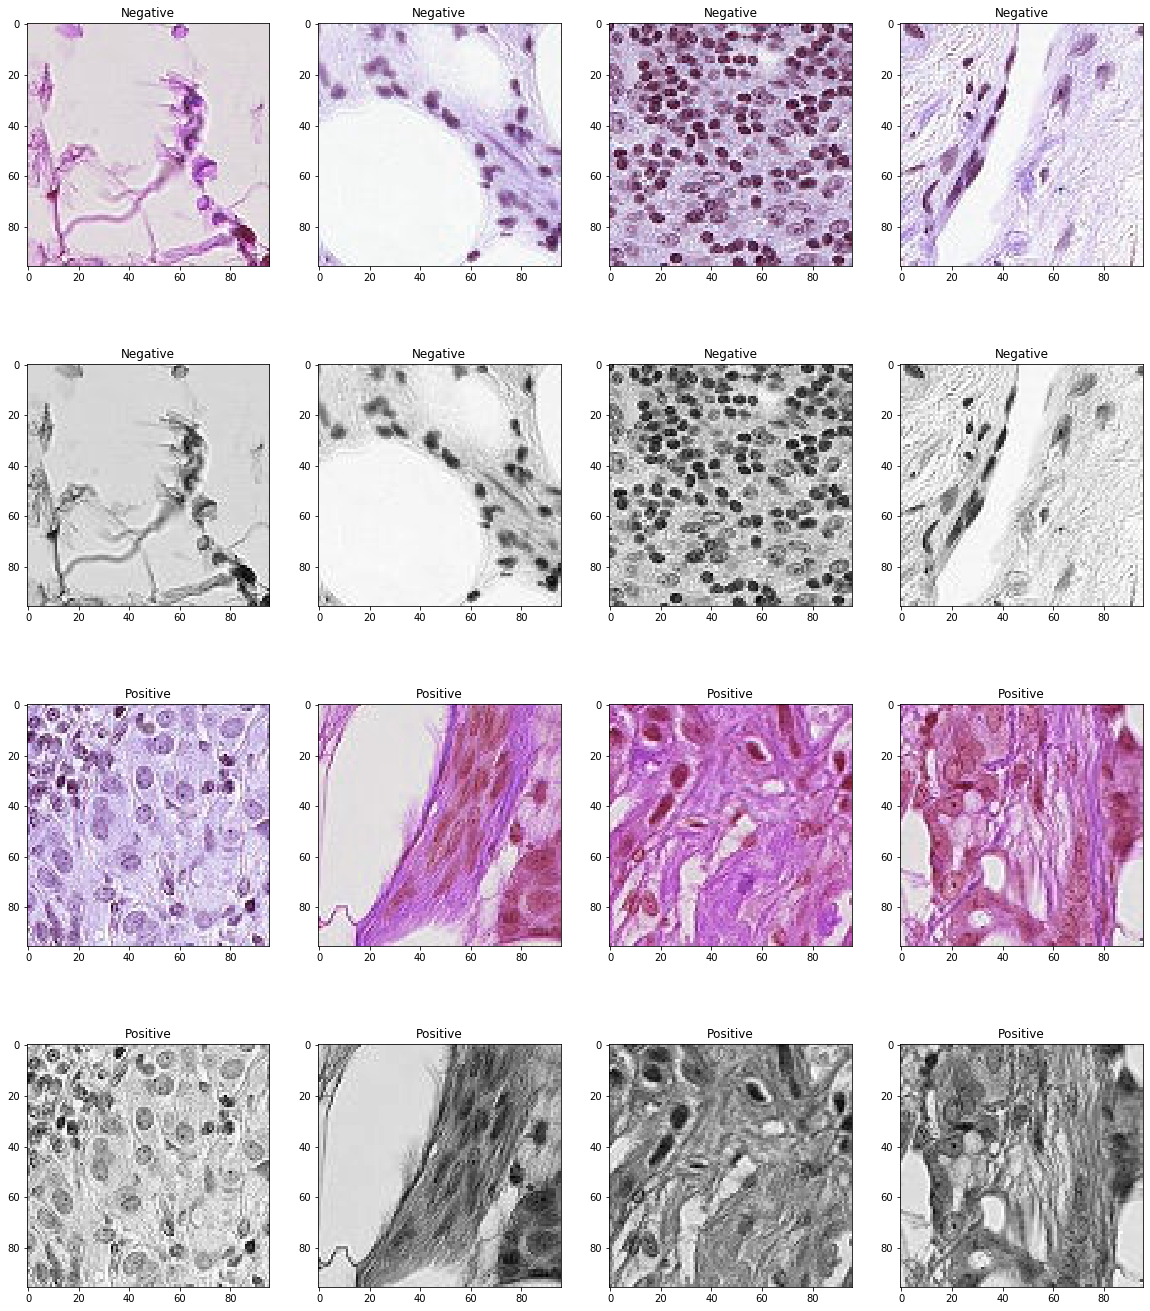

In [3]:
#select 4 negatives and 4 positives at random
shuffled_y=shuffle(y)

fig,ax = plt.subplots(4,4, figsize=(20,24))

#4 negatives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 0]['id'][:4]):
    ax[0,i].imshow(X.get(idx))
    ax[0,i].set_title('Negative')
    ax[1,i].imshow(cv2.cvtColor(X.get(idx), cv2.COLOR_BGR2GRAY), cmap='gray')
    ax[1,i].set_title('Negative')        

#4 positives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 1]['id'][:4]):
    ax[2,i].imshow(X.get(idx))
    ax[2,i].set_title('Positive')
    ax[3,i].imshow(cv2.cvtColor(X.get(idx), cv2.COLOR_BGR2GRAY), cmap='gray')
    ax[3,i].set_title('Positive') 


##### To begin looking for trends in the data, first we'll split into positive and negative groups in advance of plotting some features


In [4]:
#first sort the positive and negative slides into lists. 
X_p,X_n=[],[]
for idx,row in y.iterrows():
    if row.label==1:
        X_p.append(X.get(row.id)) 
        #X_p_g.append(X_gray.get(row.id))
    else:
        X_n.append(X.get(row.id))
        #X_n_g.append(X_gray.get(row.id))
       

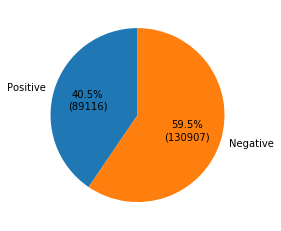

In [5]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))

labels='Positive','Negative'
data=[len(X_p),len(X_n)]
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(),labels=labels,startangle=90)

plt.show()

The dataset we are using has come from a <a href="https://www.kaggle.com/c/histopathologic-cancer-detection">Kaggle competition on Histopathic Cancer Detection.</a> It is a subset of the <a href="https://github.com/basveeling/pcam">PatchCamelyon (PCam) benchmark dataset</a>. The original dataset has a randomized set of images with equal number positive and negative samples. The Kaggle set has duplicate images removed, so the subset we are working with has the above distribution of positive and negative samples.

The dataset is made up of images, so a few ways of exploring the data come to mind:
* intensity of each of the color channels
* aggregations of the channels


In [6]:
#split the images by channel

bp,gp,rp,bn,gn,rn=[],[],[],[],[],[]
for each in X_p:
    bp,gp,rp=cv2.split(each)
for each in X_n:
    bn,gn,rn=cv2.split(each)

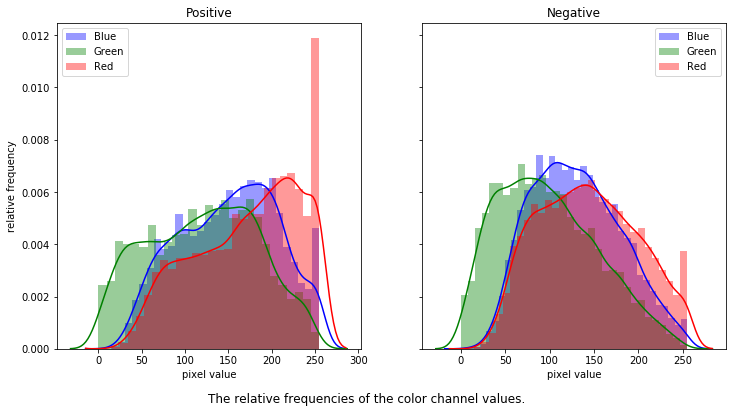

In [7]:
fig,axs = plt.subplots(1,2,sharey=True,figsize=(12,6))

sns.distplot(bp,color='blue',label='blue',ax=axs[0]).set_title('Positive')
sns.distplot(gp,color='green',label='green',ax=axs[0]).set_xlabel('pixel value')
sns.distplot(rp,color='red',label='red',ax=axs[0]).set_ylabel('relative frequency')
sns.distplot(bn,color='blue',label='blue',ax=axs[1]).set_title('Negative')
sns.distplot(gn,color='green',label='green',ax=axs[1]).set_xlabel('pixel value')
sns.distplot(rn,color='red',label='red',ax=axs[1])

axs[0].legend(labels=['Blue','Green','Red'])
axs[1].legend(labels=['Blue','Green','Red'])
plt.figtext(.3,0,'The relative frequencies of the color channel values.',fontsize='large')
plt.show()

There appears to be some differences between the positive and negative sets, so let's compare the individual color channels individually to see if anything sticks out.

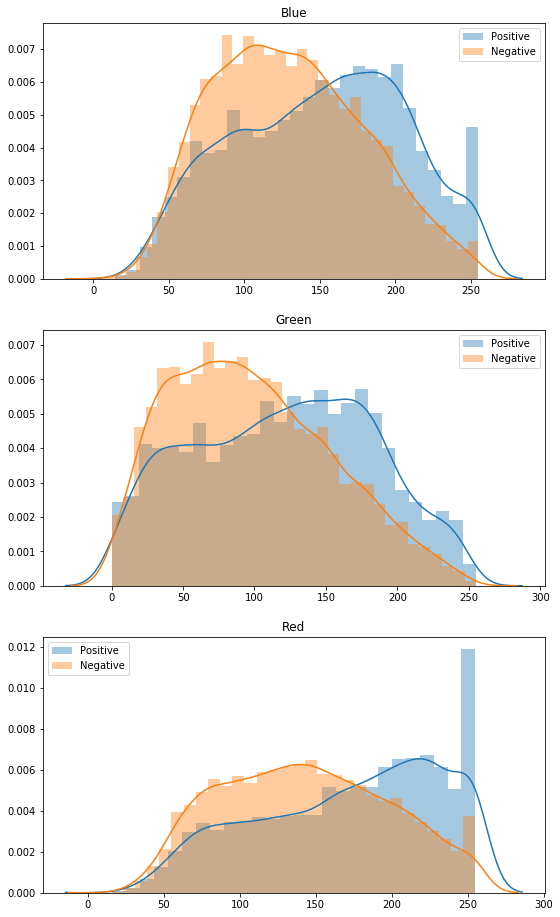

In [8]:
fig,axs = plt.subplots(3,1,figsize=(9,16))

sns.distplot(bp,label='Positive',ax=axs[0]).set_title('Blue')
sns.distplot(bn,label='Negative',ax=axs[0])
sns.distplot(gp,label='Positive',ax=axs[1]).set_title('Green')
sns.distplot(gn,label='Negative',ax=axs[1])
sns.distplot(rp,label='Positive',ax=axs[2]).set_title('Red')
sns.distplot(rn,label='Negative',ax=axs[2])
axs[0].legend(labels=['Positive','Negative'])
axs[1].legend(labels=['Positive','Negative'])
axs[2].legend(labels=['Positive','Negative'])
plt.show()

In each of the 3 color channels, the preponderance of the numerical values of the positive samples is higher.

There also seems to be quite a spike in the higher values. (255,255,255) is the encoding for the color white, so let's confirm whether this is just whitespace by looking at a histogram with 256 bins, one for each possible value

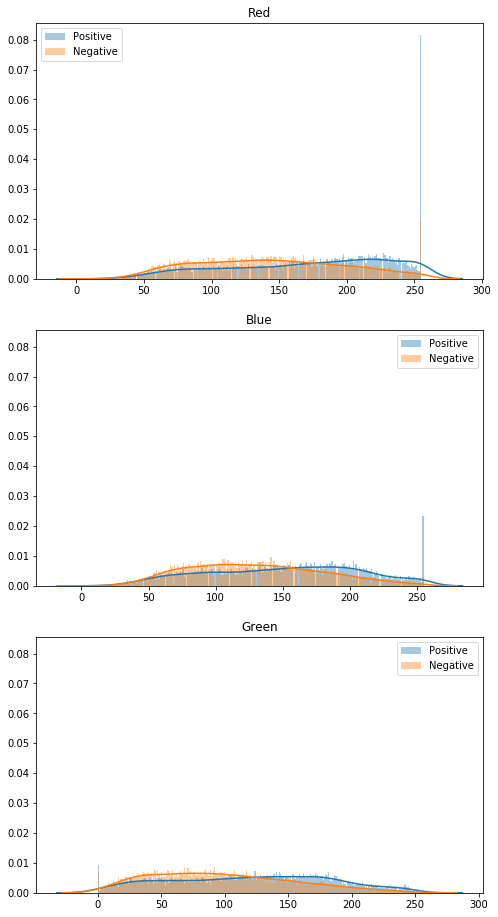

In [9]:
fig,axs = plt.subplots(3,1,figsize=(8,16),sharey=True)
plt.legend(labels=['Positive','Negative'])
sns.distplot(rp,label='Positive',bins=256,ax=axs[0]).set_title('Red')
sns.distplot(rn,label='Negative',bins=256,ax=axs[0])
sns.distplot(bp,label='Positive',bins=256,ax=axs[1]).set_title('Blue')
sns.distplot(bn,label='Negative',bins=256,ax=axs[1])
sns.distplot(gp,label='Positive',bins=256,ax=axs[2]).set_title('Green')
sns.distplot(gn,label='Negative',bins=256,ax=axs[2])
axs[0].legend(labels=['Positive','Negative'])
axs[1].legend(labels=['Positive','Negative'])
axs[2].legend(labels=['Positive','Negative'])
plt.show()

It looks like there is a larger spike in the red and blue channels than the green, so let's zoom in on just the value 255.

In [10]:
#first pull out counts of the values to plot
def count_els(L,v):
    c=0
    for each in L:
        c=c+np.count_nonzero(each==v)
    return c

In [11]:
bph=count_els(bp,255)
bnh=count_els(bn,255)
gph=count_els(gp,255)
gnh=count_els(gn,255)
rph=count_els(rp,255)
rnh=count_els(rn,255)

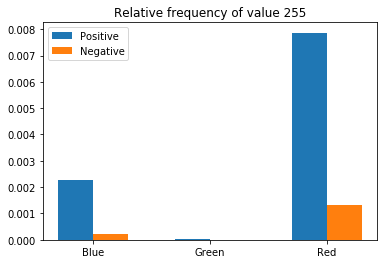

In [12]:

labels = ['Blue','Green','Red']
pos = [bph/len(X_p),gph/len(X_p),rph/len(X_p)]
neg = [bnh/len(X_n),gnh/len(X_n),rnh/len(X_n)]

x = np.arange(len(labels))
width = 0.3 

fig, ax = plt.subplots()
ax.bar(x - width/2, pos, width, label='Positive')
ax.bar(x + width/2, neg, width, label='Negative')


#ax.set_ylabel('frequency of value 255')
ax.set_title('Relative frequency of value 255')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

So the preponerance of the falue 255 isn't whitespace it is a range of color (purple to red), and this range is more common in the positive samples than in the negative.

#### To sum up the differences we begin to see in the distribution of color between positive and negative samples, among the Positive group we see:
* All channels seem shifted to the right, indicating more color in the positive samples.
* There is a spike in the red and blue channels at 255 in both positive and negative groups but it is much higher in the positive group.

#### Next we will examine the results of some aggregation to see if there is anything we can learn there.
The mean and median of the slides and of individual color channels may be interesting.

In [13]:
#create some aggregates of the data
X_p_v=[a.flatten() for a in X_p]
X_n_v=[a.flatten() for a in X_n]
X_p_mean=[np.mean(each) for each in X_p_v]
X_n_mean=[np.mean(each) for each in X_n_v]
X_p_med=[np.median(each) for each in X_p_v]
X_n_med=[np.median(each) for each in X_n_v]

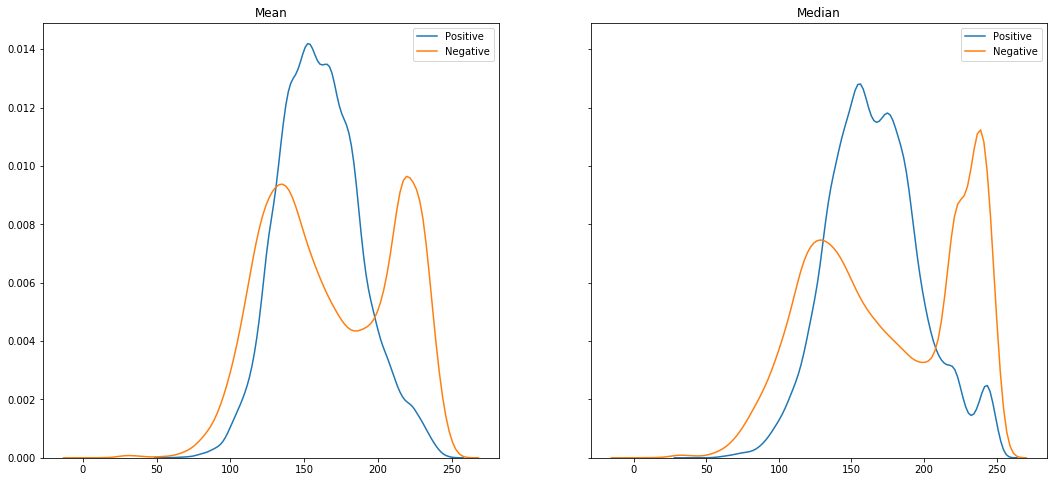

In [14]:
fig,axs = plt.subplots(1,2, sharey=True, figsize=(18,8))

sns.distplot(X_p_mean,hist=False,label='Positive',ax=axs[0]).set_title('Mean')
sns.distplot(X_n_mean,hist=False,label='Negative',ax=axs[0])
sns.distplot(X_p_med,hist=False,label='Positive',ax=axs[1]).set_title('Median')
sns.distplot(X_n_med,hist=False,label='Negative',ax=axs[1])

plt.show()

###### There is a clear difference in the distribution of the mean values of the positive and negative sets, with the negative having a bimodal distribution. The plot of the medians looks similar to the means, we can conclude from this that the data don't have a lot of outliers.

Given the obvious difference between positive and negative here, it may be informative to see if any one channel is particularly responsible. So let's look at similar aggregations for the individual color channels 

In [15]:
bp_mean=[np.mean(np.ravel(a)) for a in bp]
bn_mean=[np.mean(np.ravel(a)) for a in bn]
gp_mean=[np.mean(np.ravel(a)) for a in gp]
gn_mean=[np.mean(np.ravel(a)) for a in gn]
rp_mean=[np.mean(np.ravel(a)) for a in rp]
rn_mean=[np.mean(np.ravel(a)) for a in rn]

In [16]:
bp_med=[np.median(np.ravel(a)) for a in bp]
bn_med=[np.median(np.ravel(a)) for a in bn]
gp_med=[np.median(np.ravel(a)) for a in gp]
gn_med=[np.median(np.ravel(a)) for a in gn]
rp_med=[np.median(np.ravel(a)) for a in rp]
rn_med=[np.median(np.ravel(a)) for a in rn]

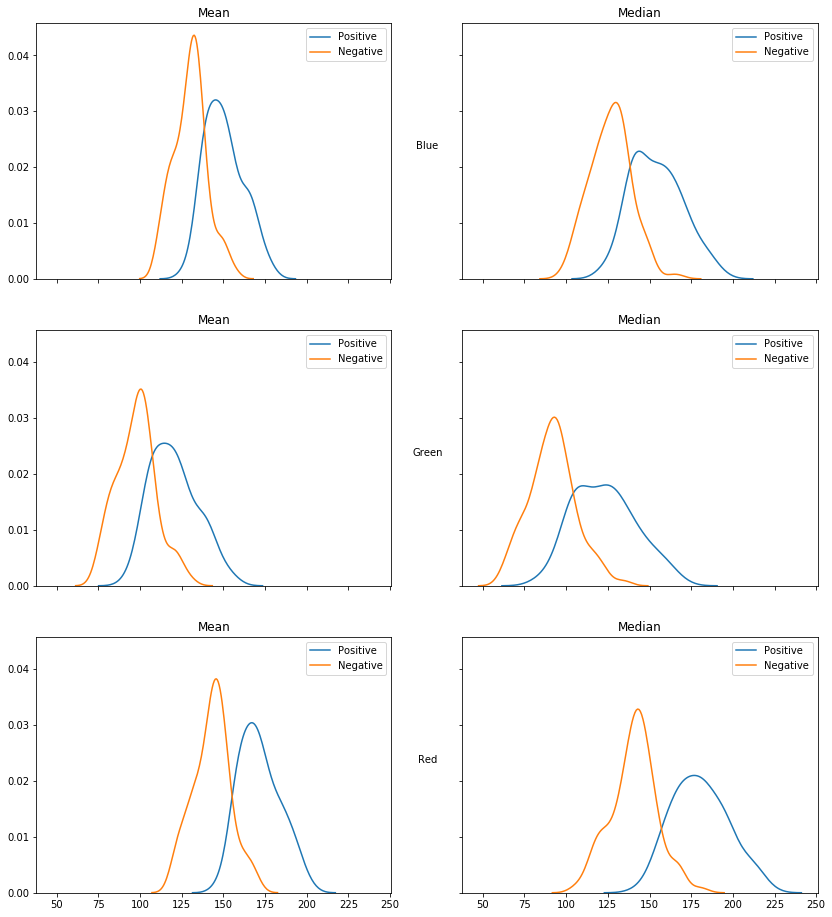

In [17]:
fig,axs = plt.subplots(3,2, sharey=True, sharex=True,figsize=(14,16))

sns.distplot(gp_mean,hist=False,label='Positive',ax=axs[1,0]).set_title('Mean')
sns.distplot(gn_mean,hist=False,label='Negative',ax=axs[1,0])
sns.distplot(gp_med,hist=False,label='Positive',ax=axs[1,1]).set_title('Median')
sns.distplot(gn_med,hist=False,label='Negative',ax=axs[1,1]).set_ylabel("Green",rotation='horizontal',labelpad=35)
sns.distplot(rp_mean,hist=False,label='Positive',ax=axs[2,0]).set_title('Mean')
sns.distplot(rn_mean,hist=False,label='Negative',ax=axs[2,0])
sns.distplot(rp_med,hist=False,label='Positive',ax=axs[2,1]).set_title('Median')
sns.distplot(rn_med,hist=False,label='Negative',ax=axs[2,1]).set_ylabel("Red",rotation='horizontal',labelpad=35)
sns.distplot(bp_mean,hist=False,label='Positive',ax=axs[0,0]).set_title('Mean')
sns.distplot(bn_mean,hist=False,label='Negative',ax=axs[0,0])
sns.distplot(bp_med,hist=False,label='Positive',ax=axs[0,1]).set_title('Median')
sns.distplot(bn_med,hist=False,label='Negative',ax=axs[0,1]).set_ylabel("Blue",rotation='horizontal',labelpad=35)

plt.show()

There is a pretty significant difference in all channels. In the positive samples, the distribution of the mean and median values are all greater and somewhat more evenly distributed.

#### Truncating the data
According to the PCam documentation a Positive slide is defined as having a single positive pixel within a 32x32 pixel square at the center of the 96x96 slide. 

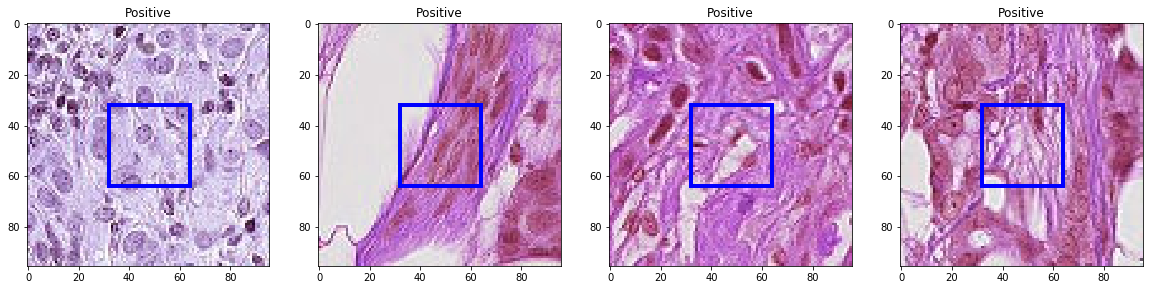

In [18]:
fig,ax = plt.subplots(1,4, figsize=(20,24))  

#4 positives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 1]['id'][:4]):
    ax[i].imshow(X.get(idx))
    ax[i].set_title('Positive')
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle='solid', capstyle='round')
    ax[i].add_patch(box)

If there is a significant difference between these areas and the entire images, we may be able to work more efficiently by cropping to the center and using the cropped dataset.

To examine these and compare them, first we'll crop the images to the center by slicing the arrays:

In [19]:
X_p_c=[a[31:63,31:63] for a in X_p]
X_n_c=[a[31:63,31:63] for a in X_n]
bp_c=[a[31:63]for a in bp]
bn_c=[a[31:63]for a in bn]
gp_c=[a[31:63]for a in gp]
gn_c=[a[31:63]for a in gn]
rp_c=[a[31:63]for a in rp]
rn_c=[a[31:63]for a in rn]


Then, we can compare them to the full images

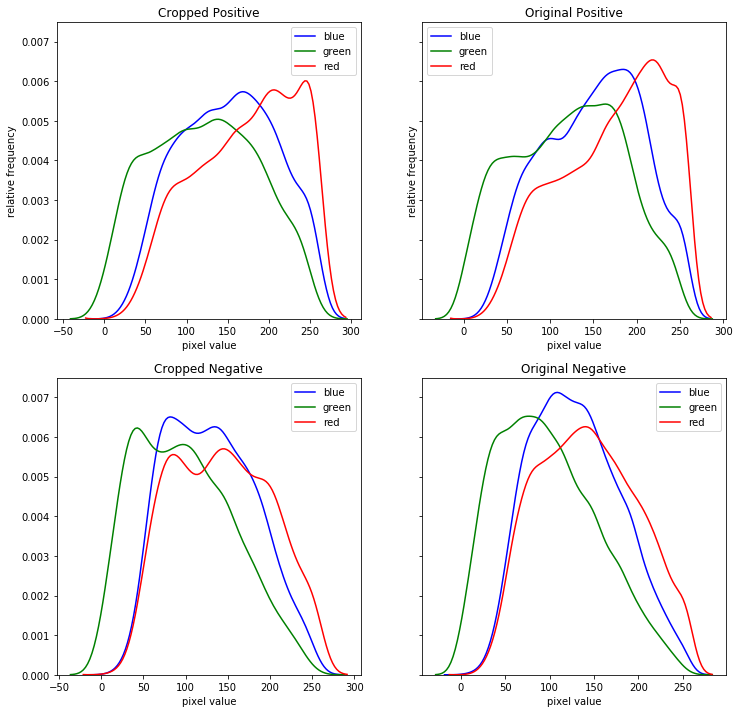

In [20]:
fig,axs = plt.subplots(2,2,sharey=True,figsize=(12,12))

sns.distplot(bp_c,hist=False,color='blue',label='blue',ax=axs[0,0]).set_title('Cropped Positive')
sns.distplot(gp_c,hist=False,color='green',label='green',ax=axs[0,0]).set_xlabel('pixel value')
sns.distplot(rp_c,hist=False,color='red',label='red',ax=axs[0,0]).set_ylabel('relative frequency')
sns.distplot(bn_c,hist=False,color='blue',label='blue',ax=axs[1,0]).set_title('Cropped Negative')
sns.distplot(gn_c,hist=False,color='green',label='green',ax=axs[1,0]).set_xlabel('pixel value')
sns.distplot(rn_c,hist=False,color='red',label='red',ax=axs[1,0])

sns.distplot(bp,hist=False,color='blue',label='blue',ax=axs[0,1]).set_title('Original Positive')
sns.distplot(gp,hist=False,color='green',label='green',ax=axs[0,1]).set_xlabel('pixel value')
sns.distplot(rp,hist=False,color='red',label='red',ax=axs[0,1]).set_ylabel('relative frequency')
sns.distplot(bn,hist=False,color='blue',label='blue',ax=axs[1,1]).set_title('Original Negative')
sns.distplot(gn,hist=False,color='green',label='green',ax=axs[1,1]).set_xlabel('pixel value')
sns.distplot(rn,hist=False,color='red',label='red',ax=axs[1,1])

plt.show()

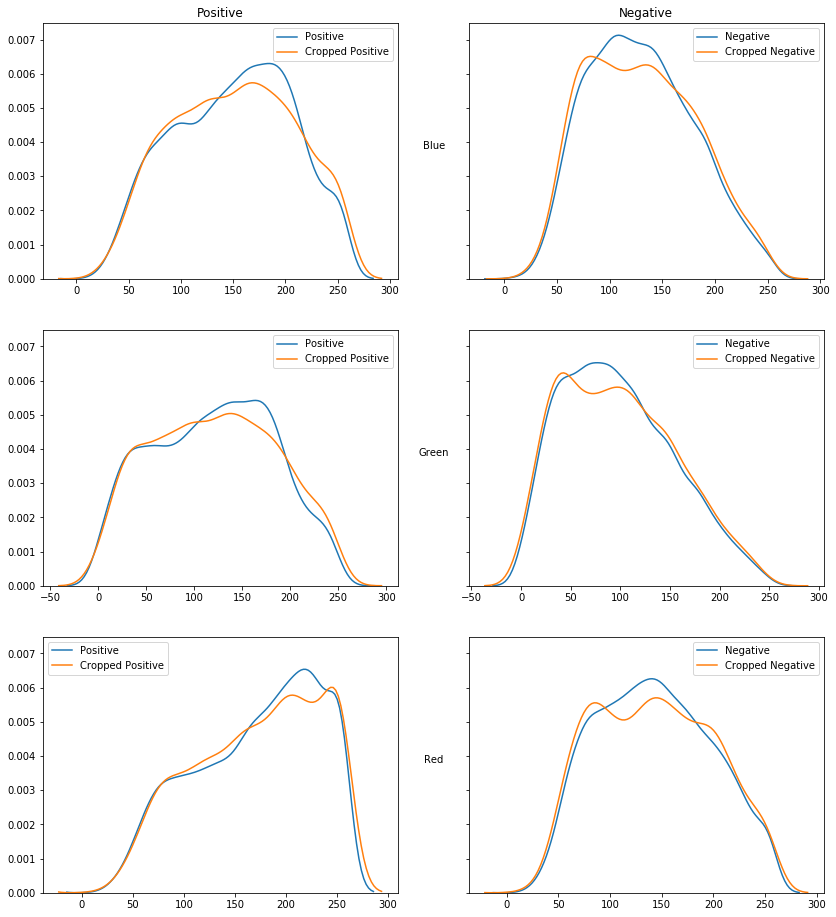

In [21]:
#individual channels
fig,axs = plt.subplots(3,2,figsize=(14,16),sharey=True)

sns.distplot(bp,hist=False,label='Positive',ax=axs[0,0]).set_title('Positive')
sns.distplot(bn,hist=False,label='Negative',ax=axs[0,1]).set_title('Negative')
sns.distplot(gp,hist=False,label='Positive',ax=axs[1,0])
sns.distplot(gn,hist=False,label='Negative',ax=axs[1,1])
sns.distplot(rp,hist=False,label='Positive',ax=axs[2,0])
sns.distplot(rn,hist=False,label='Negative',ax=axs[2,1])

sns.distplot(bp_c,hist=False,label='Cropped Positive',ax=axs[0,0])
sns.distplot(bn_c,hist=False,label='Cropped Negative',ax=axs[0,1]).set_ylabel("Blue",rotation='horizontal',labelpad=35)
sns.distplot(gp_c,hist=False,label='Cropped Positive',ax=axs[1,0])
sns.distplot(gn_c,hist=False,label='Cropped Negative',ax=axs[1,1]).set_ylabel("Green",rotation='horizontal',labelpad=35)
sns.distplot(rp_c,hist=False,label='Cropped Positive',ax=axs[2,0])
sns.distplot(rn_c,hist=False,label='Cropped Negative',ax=axs[2,1]).set_ylabel("Red",rotation='horizontal',labelpad=35)


plt.show()

##### Let's zoom in on the value 255 like we did for the full images

In [22]:
bpch=count_els(bp_c,255)
bnch=count_els(bn_c,255)
gpch=count_els(gp_c,255)
gnch=count_els(gn_c,255)
rpch=count_els(rp_c,255)
rnch=count_els(rn_c,255)

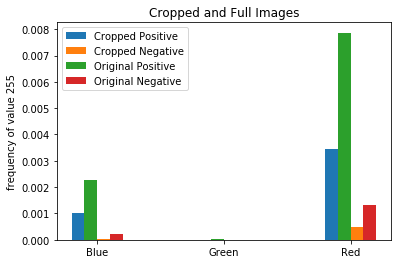

In [23]:

labels = ['Blue','Green','Red']
pos_c = [bpch/len(X_p),gpch/len(X_p),rpch/len(X_p)]
neg_c = [bnch/len(X_n),gnch/len(X_n),rnch/len(X_n)]
pos = [bph/len(X_p),gph/len(X_p),rph/len(X_p)]
neg = [bnh/len(X_n),gnh/len(X_n),rnh/len(X_n)]

x = np.arange(len(labels))
width = 0.1 

fig, ax = plt.subplots()
ax.bar(x - 1.5*width, pos_c, width, label='Cropped Positive')
ax.bar(x + width/2, neg_c, width, label='Cropped Negative')

ax.bar(x - width/2, pos, width, label='Original Positive')
ax.bar(x + 1.5*width, neg, width, label='Original Negative')

ax.set_ylabel('frequency of value 255')
ax.set_title('Cropped and Full Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

We can see from the above histogram that the spike in the red and blue channels at 255 in the positive samples is also present in the cropped images, but less pronounced.

In [24]:
#create some aggregates of the data
X_p_c_v=[a.flatten() for a in X_p_c]
X_n_c_v=[a.flatten() for a in X_n_c]
X_p_c_mean=[np.mean(each) for each in X_p_c_v]
X_n_c_mean=[np.mean(each) for each in X_n_c_v]
X_p_c_med=[np.median(each) for each in X_p_c_v]
X_n_c_med=[np.median(each) for each in X_n_c_v]

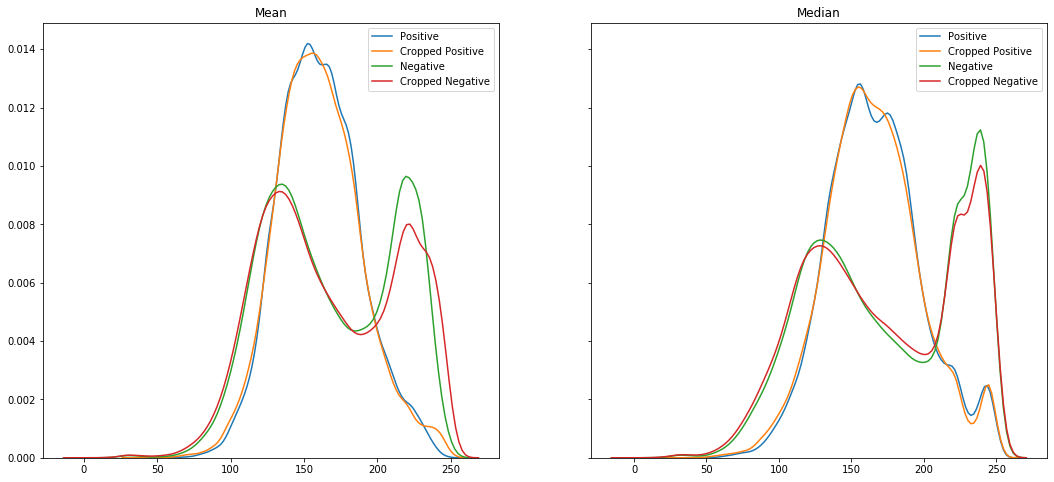

In [25]:
fig,axs = plt.subplots(1,2, sharey=True, figsize=(18,8))

sns.distplot(X_p_mean,hist=False,label='Positive',ax=axs[0]).set_title('Mean')
sns.distplot(X_p_c_mean,hist=False,label='Cropped Positive',ax=axs[0])
sns.distplot(X_n_mean,hist=False,label='Negative',ax=axs[0])
sns.distplot(X_n_c_mean,hist=False,label='Cropped Negative',ax=axs[0])

sns.distplot(X_p_med,hist=False,label='Positive',ax=axs[1]).set_title('Median')
sns.distplot(X_p_c_med,hist=False,label='Cropped Positive',ax=axs[1])
sns.distplot(X_n_med,hist=False,label='Negative',ax=axs[1])
sns.distplot(X_n_c_med,hist=False,label='Cropped Negative',ax=axs[1])


plt.show()

Aggregate values so far don't show much consistent difference between using the entire images and the cener square.

In [26]:
bp_c_mean=[np.mean(np.ravel(a)) for a in bp_c]
bn_c_mean=[np.mean(np.ravel(a)) for a in bn_c]
gp_c_mean=[np.mean(np.ravel(a)) for a in gp_c]
gn_c_mean=[np.mean(np.ravel(a)) for a in gn_c]
rp_c_mean=[np.mean(np.ravel(a)) for a in rp_c]
rn_c_mean=[np.mean(np.ravel(a)) for a in rn_c]

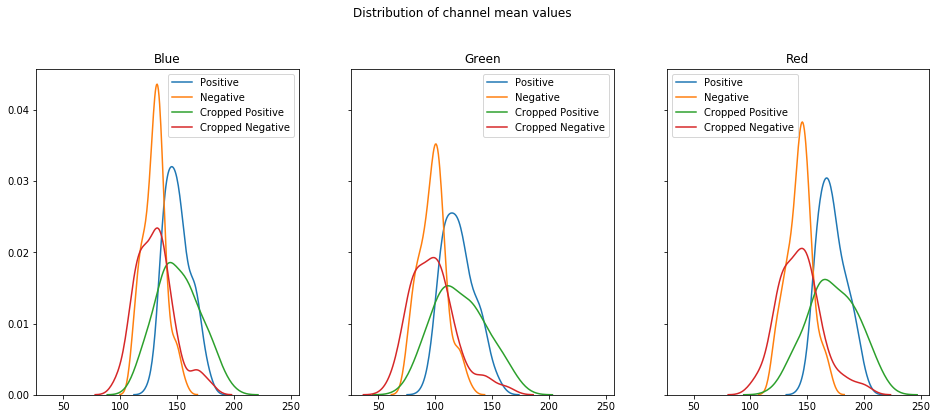

In [27]:
fig,axs = plt.subplots(1,3, sharey=True, sharex=True,figsize=(16,6))

sns.distplot(bp_mean,hist=False,label='Positive',ax=axs[0]).set_title('Blue')
sns.distplot(bn_mean,hist=False,label='Negative',ax=axs[0])
sns.distplot(gp_mean,hist=False,label='Positive',ax=axs[1]).set_title('Green')
sns.distplot(gn_mean,hist=False,label='Negative',ax=axs[1])
sns.distplot(rp_mean,hist=False,label='Positive',ax=axs[2]).set_title('Red')
sns.distplot(rn_mean,hist=False,label='Negative',ax=axs[2])

sns.distplot(bp_c_mean,hist=False,label='Cropped Positive',ax=axs[0])
sns.distplot(bn_c_mean,hist=False,label='Cropped Negative',ax=axs[0])
sns.distplot(gp_c_mean,hist=False,label='Cropped Positive',ax=axs[1])
sns.distplot(gn_c_mean,hist=False,label='Cropped Negative',ax=axs[1])
sns.distplot(rp_c_mean,hist=False,label='Cropped Positive',ax=axs[2])
sns.distplot(rn_c_mean,hist=False,label='Cropped Negative',ax=axs[2])

plt.figtext(.4,1,'Distribution of channel mean values',fontsize='large')
plt.show()

The aggregate values of the individual channels in the cropped images show the same trends as in the full images, but the values are a little more widely distributed. 

As the differences between the positive and negative images seem to be somewhat more pronounced when the entire image is observed, we may be able to expect more accurate classification using the entire images.